<a href="https://colab.research.google.com/github/snavasg/Airline-Market-Quantitive-Processing/blob/main/Aerocivil_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

path= '/content/drive/MyDrive/Tesis/' #! Path definition 
file_aero = 'Aerocivil.txt' #! File definition 
file_price = 'Precios.txt'

# AEROCIVIL


## PROCESAMIENTO TABLA AEROCIVIL


In [ ]:
# PROCESAMIENTO TABLA AEROCIVIL
p_f =  path + file_aero
data = pd.read_csv(p_f, sep="\t")
df =data
df = df.replace('(en blanco)', '0') 

df =df[['Año','Mes', 'CiudadDestino','Destino','Destino_MC',
        'NombreAeropuertoDestino','CiudadOrigen','Origen','Origen_MC', 
        'NombreAeropuertoOrigen','Leg', 'MarketLeg','Airline_Cod',
        'NombredeEmpresa','SiglaEmpresa','Trafico','TipoVuelo','Ruta_Viva',
        'NumerodeVuelos','PasajerosABordo','PasajerosTransito',
        'SillasOfrecidas','KM','LF','PDEWS','Weekly_Frequencies']]

df =df.sort_values(['Año','Mes','MarketLeg']).reset_index()

df[['KM',	'LF',	'PDEWS','Weekly_Frequencies']]=df[['KM',	'LF',	'PDEWS',
                                        'Weekly_Frequencies']].astype('string')


for x in ['KM',	'LF',	'PDEWS','Weekly_Frequencies']: 
  df[x]=df[x].apply(lambda x: x.replace(',', '.'))

  
df[['NumerodeVuelos',	'PasajerosABordo',	'PasajerosTransito',	
    'SillasOfrecidas','KM',	'LF',
    'PDEWS','Weekly_Frequencies']]=df[['NumerodeVuelos',	'PasajerosABordo',	
                                       'PasajerosTransito',	'SillasOfrecidas',
                                       'KM',	'LF','PDEWS',
                                       'Weekly_Frequencies']].astype('float')

df['Date'] = df['Mes'].astype('string')  + df['Año'].astype('string')
df['Date'] = pd.to_datetime(df['Date'], format='%m%Y')

# GENERANDO GRUPOS PARA DATA 

df['Company'] = df['Airline_Cod'].apply(lambda x: 'Other' if x != 'AV'and
                                         x != 'LA' and
                                         x != 'VH' and
                                         x != 'VE'
                                       else ('Avianca' if x == 'AV' 
                                          else ('Latam' if x == 'LA' 
                                             else ('Viva' if x == 'VH' 
                                               else('Easy Fly' if x=='VE' 
                                                 else 'no match')))))

# LO PROXIMO NO ES VIABLE PORQUE LA TABLA DE PRECIOS NO TIENE ORIGEN 
# Y DESTINO MC
df['Leg'] = df['Leg'].str.replace('EOH', 'MDE')

df['MarketLeg'] = df['MarketLeg'].str.replace('EOH', 'MDE')

df['Origen'] = df['Origen'].str.replace('EOH', 'MDE')

df['Destino'] = df['Destino'].str.replace('EOH', 'MDE')

df['CiudadDestino'] =df['CiudadDestino'].str.replace('RIONEGRO - ANTIOQUIA',
                                                     'MEDELLIN')

df['CiudadOrigen'] =df['CiudadOrigen'].str.replace('MEDELLIN', 
                                                   'RIONEGRO - ANTIOQUIA')

df['Ruta_Viva'] = (df['Ruta_Viva'].str.replace('Si', '1')).astype('float')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3,4,5,18,24,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# CREANDO DF Y DF_FULL
df_full = df[(df['TipoVuelo'] == "R") & (df['Trafico'] == "N")].reset_index()
df= df[(df['TipoVuelo'] == "R") & (df['Trafico'] == "N")  & (df['Año']>= 2021)].reset_index()

# CAMBIAR ULS por OL
df['Airline_Cod']=df['Airline_Cod'].replace('ULS', 'OL')
# BORRANDO LAS AEROLINEAS QUE NO SE ENCUENTRAN EN LA DATA DE PRECIOS DE AEROCIVIL
df = df[(df['Airline_Cod']!= 'CM') & (df['Airline_Cod']!= 'OTROS') ]

# Agrupemos los datos para borrar los duplicados

df=df.groupby(['Año','Mes','Date', 'CiudadDestino','Destino','Destino_MC',
               'CiudadOrigen','Origen','Origen_MC','Leg' , 'MarketLeg',
               'Airline_Cod','Company','Trafico','TipoVuelo'] ,
              as_index=False).agg({'Ruta_Viva':'sum','NumerodeVuelos':'sum', 
                                   'NumerodeVuelos':'sum',
                                   'PasajerosABordo':'sum',
                                   'PasajerosTransito':'sum',
                                   'SillasOfrecidas':'sum',
                                   'KM':'mean','LF':'mean',
                                   'PDEWS':'mean','Weekly_Frequencies':'mean' })
      

df_full=df_full.groupby(['Año','Mes','Date', 'CiudadDestino','Destino',
                         'Destino_MC','CiudadOrigen','Origen','Origen_MC',
                         'Leg', 'MarketLeg','Airline_Cod','Company' ,
                         'Trafico','TipoVuelo'] ,
                        as_index=False).agg({'Ruta_Viva':'sum',
                                             'NumerodeVuelos':'sum', 
                                             'NumerodeVuelos':'sum',
                                             'PasajerosABordo':'sum',
                                             'PasajerosTransito':'sum',
                                             'SillasOfrecidas':'sum',
                                             'KM':'mean','LF':'mean',
                                             'PDEWS':'mean',
                                             'Weekly_Frequencies':'mean' })



# REDUZACAMOS LA MUESTRA A NUESTRO NIVEL DE OBSERVACION DE UN AÑO 
df['Date'] = pd.to_datetime(df['Date']).dt.to_period('M')
df = df[df['Date']>= '2021-02']

# CREEMOS UN HHI POR RUTA Y PERIODO, PARA LUEGO AGREGARLO A DF

mk_share_for_hhi = df.groupby(['Date','Leg','Airline_Cod'], 
                              as_index=False)['PasajerosABordo'].agg('sum')
                              
mk_share_for_hhi['id_HHI_treatment'] = mk_share_for_hhi['Date'].astype(str) + mk_share_for_hhi['Leg']
mk_share_for_hhi['id_m_share'] = mk_share_for_hhi['Date'].astype(str) + mk_share_for_hhi['Leg'] +mk_share_for_hhi['Airline_Cod']

consol_hhi =df.groupby(['Date', 'Leg'],
                       as_index=False)['PasajerosABordo'].agg('sum')

consol_hhi.rename(columns = {'PasajerosABordo':'PasajerosABordo_sum'}, 
                  inplace = True)

consol_hhi['id_HHI_treatment'] = consol_hhi['Date'].astype(str) + consol_hhi['Leg']
mk_share_for_hhi = mk_share_for_hhi.merge(consol_hhi, on='id_HHI_treatment', 
                                          how='left')

# UNAMOS EL MARKET SHARE CON DF
mk_share_for_hhi['m_share'] = (mk_share_for_hhi['PasajerosABordo']/ mk_share_for_hhi['PasajerosABordo_sum'])
df['id_m_share'] = df['Date'].astype(str) + df['Leg'] +df['Airline_Cod']
df_m_share = mk_share_for_hhi[['id_m_share', 'm_share']]
df = df.merge(df_m_share, on='id_m_share', how='left')



mk_share_for_hhi['HHI'] = (mk_share_for_hhi['m_share'].pow(2,axis=0))

mk_share_for_hhi = mk_share_for_hhi.groupby(['id_HHI_treatment','Date_x', 'Leg_x'], as_index=False)['HHI'].agg('sum')

df['id_HHI_treatment'] = df['Date'].astype(str) + df['Leg']
mk_share_for_hhi = mk_share_for_hhi[['id_HHI_treatment', 'HHI']]
df = df.merge(mk_share_for_hhi, on='id_HHI_treatment', how='left')

# CREEMOS UN HHI POR RUTA Y LEG, PARA SIILAS OFRECIDAS

mk_share_for_hhi = df.groupby(['Date','Leg','Airline_Cod'], as_index=False)['SillasOfrecidas'].agg('sum')
mk_share_for_hhi['id_HHI_treatment'] = mk_share_for_hhi['Date'].astype(str) + mk_share_for_hhi['Leg']

consol_hhi =df.groupby(['Date', 'Leg'], as_index=False)['SillasOfrecidas'].agg('sum')
consol_hhi.rename(columns = {'SillasOfrecidas':'SillasOfrecidas_sum'}, inplace = True)
consol_hhi['id_HHI_treatment'] = consol_hhi['Date'].astype(str) + consol_hhi['Leg']
mk_share_for_hhi = mk_share_for_hhi.merge(consol_hhi, on='id_HHI_treatment', how='left')




mk_share_for_hhi['m_share'] = (mk_share_for_hhi['SillasOfrecidas']/ mk_share_for_hhi['SillasOfrecidas_sum'])



mk_share_for_hhi['HHI_O'] = (mk_share_for_hhi['m_share'].pow(2,axis=0))
mk_share_for_hhi = mk_share_for_hhi.groupby(['id_HHI_treatment','Date_x', 'Leg_x'], as_index=False)['HHI_O'].agg('sum')
mk_share_for_hhi = mk_share_for_hhi[['id_HHI_treatment', 'HHI_O']]
df = df.merge(mk_share_for_hhi, on='id_HHI_treatment', how='left')


# CREEMOS UN HHI POR RUTA Y LEG, PARA Numero de vuelos

# mk_share_for_hhi = df.groupby(['Date','Leg','Airline_Cod'], as_index=False)['NumerodeVuelos'].agg('sum')
# mk_share_for_hhi['id_HHI_treatment'] = mk_share_for_hhi['Date'].astype(str) + mk_share_for_hhi['Leg']

# consol_hhi =df.groupby(['Date', 'Leg'], as_index=False)['NumerodeVuelos'].agg('sum')
# consol_hhi.rename(columns = {'NumerodeVuelos':'NumerodeVuelos_sum'}, inplace = True)
# consol_hhi['id_HHI_treatment'] = consol_hhi['Date'].astype(str) + consol_hhi['Leg']

# mk_share_for_hhi = mk_share_for_hhi.merge(consol_hhi, on='id_HHI_treatment', how='left')


# mk_share_for_hhi['m_share'] = (mk_share_for_hhi['NumerodeVuelos']/ mk_share_for_hhi['NumerodeVuelos_sum'])
# mk_share_for_hhi['HHI_N'] = (mk_share_for_hhi['m_share'].pow(2,axis=0))

# mk_share_for_hhi = mk_share_for_hhi.groupby(['id_HHI_treatment','Date_x', 'Leg_x'], as_index=False)['HHI_N'].agg('sum')


# mk_share_for_hhi = mk_share_for_hhi[['id_HHI_treatment', 'HHI_N']]
# df = df.merge(mk_share_for_hhi, on='id_HHI_treatment', how='left')


# CREEMOS LAS VARIABLES DE TRATAMIENTO 

df['OL_Presence'] =np.where(df['Airline_Cod'] == 'OL', 1, 0)
df['OL_entrance'] =np.where(df['Date'] > '2022-03', 1, 0)
df['AV_VH_Presence'] = np.where((df['Airline_Cod'] == 'AV') | (df['Airline_Cod'] == 'VH'), 1, 0)
df['Merge_Effect'] = np.where(df['Date'] > '2022-04', 1, 0)

treatment = df.groupby(['Date','Leg'], 
                       as_index=False)['OL_Presence','OL_entrance',
                                       'AV_VH_Presence',
                                       'Merge_Effect'].agg('sum')

treatment = df.groupby(['Date','Leg'], 
                       as_index=False)['OL_Presence','OL_entrance',
                                       'AV_VH_Presence',
                                       'Merge_Effect'].agg('sum')

TREATMENT = ['OL_Presence','OL_entrance','Merge_Effect']

for i in TREATMENT:
  treatment[i] = np.where(treatment[i]>=1,1,0)

treatment['AV_VH_Presence'] = np.where(treatment['AV_VH_Presence']>1,1,0)

df = df.drop(columns=['OL_Presence','OL_entrance',
                      'AV_VH_Presence','Merge_Effect'])

treatment_2 = treatment.groupby('Leg', 
                                as_index = False)['OL_Presence',
                                                         'AV_VH_Presence'].agg(sum)
TREATMENT_2 = ['OL_Presence','AV_VH_Presence']


for i in TREATMENT_2:
  treatment_2[i] = np.where(treatment_2[i]>=1,1,0)
  

treatment = treatment[[ 'OL_entrance','Merge_Effect', 'Leg', 'Date']]
treatment = treatment.merge(treatment_2, on='Leg', how='left')

treatment['id_HHI_treatment'] = treatment['Date'].astype(str) + treatment['Leg']
treatment = treatment[['id_HHI_treatment', 'OL_Presence','OL_entrance'
,'AV_VH_Presence','Merge_Effect']]

df = df.merge(treatment, on='id_HHI_treatment', how='left')



In [ ]:
#exportemos para graficos de tendencias paralelas
df_to_stata = df

df_to_stata['Date'] = df_to_stata['Año'].astype(str)+'-' +df_to_stata['Mes'].astype(str)

df_to_stata.to_stata('Data_for_trends.dta')

df = df[df['Date']>= '2021-02']


## ALGUNOS OUTPUTS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


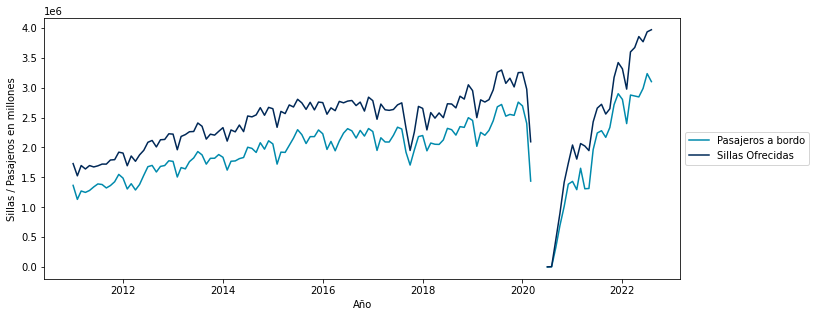

In [ ]:
# SILLAS Y PASAJEROS A BORDO A TRAVES DEL TIEMPO

tried=df_full.groupby(['Date'], as_index=False)['PasajerosABordo','SillasOfrecidas'].agg('sum')

tried = tried.replace(0,np.nan)
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(tried.Date, tried.PasajerosABordo, label= 'Pasajeros a bordo', color = '#008AAC')
plt.plot(tried.Date,  tried.SillasOfrecidas, label = 'Sillas Ofrecidas', color = '#002857')
plt.xlabel("Año")
plt.ylabel("Sillas / Pasajeros en millones")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.9, box.height*1.2])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig('Silla_Pasajero.png')
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

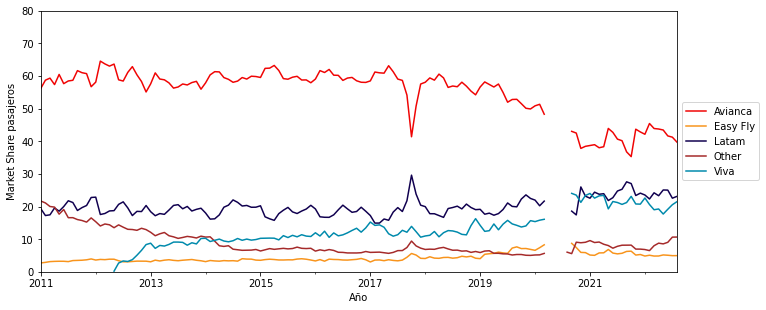

In [ ]:
#SHARES DE MERCADO

mk_share = df_full.groupby(['Date','Company'], as_index=False)['PasajerosABordo','SillasOfrecidas'].agg('sum')

consol =df_full.groupby(['Date'], as_index=False)['PasajerosABordo'].agg('sum')
consol.rename(columns = {'PasajerosABordo':'PasajerosABordo_sum'}, inplace = True)

mk_share = mk_share.merge(consol, on='Date', how='left')
mk_share['m_share'] = (mk_share['PasajerosABordo']/ mk_share['PasajerosABordo_sum'])*100
mk_share['m_share'] = mk_share['m_share'].replace(0, np.nan)
mk_share.m_share = np.where((mk_share.m_share > 90) & (mk_share.m_share < 100), np.NaN, mk_share.m_share)
pivot_mk_share =mk_share.pivot( index = 'Date', columns="Company", values="m_share")

fig = plt.figure()
w = pivot_mk_share.plot(color= ['#f00404','#f8941c','#10004f','Brown','#008AAC'])
plt.xlabel("Año")
plt.ylabel("Market Share pasajeros")
box = w.get_position()
w.set_position([box.x0, box.y0, box.width * 1.9, box.height*1.2])
w.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,80)
fig.savefig('Market_share.png')
plt.show()


<Figure size 432x288 with 0 Axes>

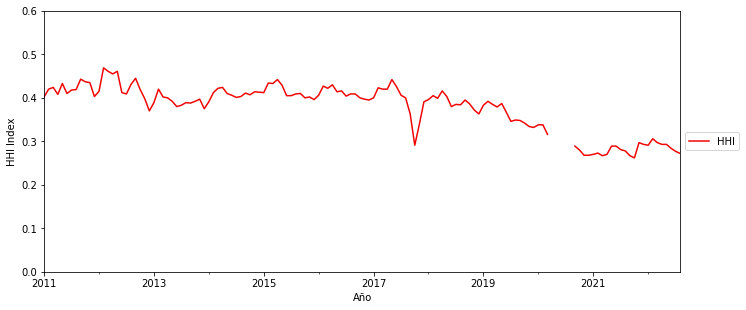

In [ ]:
# HHI INDEX ANALYSIS
pivot_mk_share_HHI =pivot_mk_share 
#pivot_mk_share_HHI=pivot_mk_share_HHI.replace(np.nan,0)

pivot_mk_share_HHI = pivot_mk_share_HHI/100
pivot_mk_share_HHI['HHI'] = (pivot_mk_share_HHI.pow(2,axis=1).sum(axis=1))
pivot_mk_share_HHI=pivot_mk_share_HHI.replace(0,np.nan)
pivot_mk_share_HHI.HHI = np.where((pivot_mk_share_HHI.HHI > 0.9) & (pivot_mk_share_HHI.HHI <= 1) | (pivot_mk_share_HHI.HHI <= 0.1), np.NaN, pivot_mk_share_HHI.HHI)
pivot_mk_share_HHI = round(pivot_mk_share_HHI[['HHI']],3)
pivot_mk_share_HHI

fig = plt.figure()
w = pivot_mk_share_HHI.plot(color= ['#f00404'])
plt.xlabel("Año")
plt.ylabel("HHI Index")
box = w.get_position()
w.set_position([box.x0, box.y0, box.width * 1.9, box.height*1.2])
w.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,0.6)
plt.show()

<Figure size 432x288 with 0 Axes>

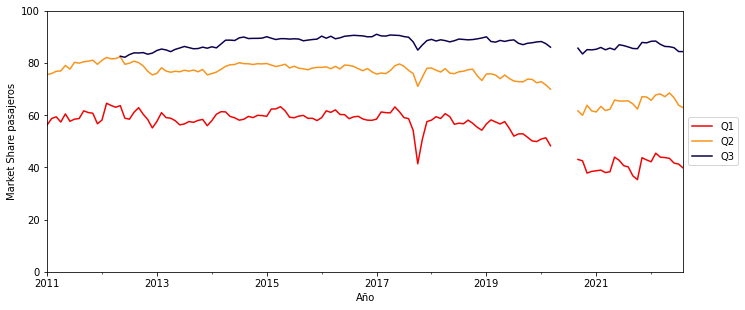

In [ ]:
# Q'S ANALYSIS

pivot_mk_share['Q1'] = pivot_mk_share['Avianca']
pivot_mk_share['Q2'] = pivot_mk_share['Q1'] + pivot_mk_share['Latam']
pivot_mk_share['Q3'] =  pivot_mk_share['Q2'] + pivot_mk_share['Viva']

pivot_mk_share_QS=pivot_mk_share[['Q1','Q2','Q3']]

fig = plt.figure()
w = pivot_mk_share_QS.plot(color= ['#f00404','#f8941c','#10004f','Brown','#008AAC'])
plt.xlabel("Año")
plt.ylabel("Market Share pasajeros")
box = w.get_position()
w.set_position([box.x0, box.y0, box.width * 1.9, box.height*1.2])
w.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,100)
fig.savefig('Market_share.png')
plt.show()

In [ ]:
# top 10 shares by leg 
df_top_10 = df.groupby(['Leg', 'MarketLeg'],as_index = False)['PasajerosABordo','SillasOfrecidas','NumerodeVuelos'].sum()
df_top_10['Share de Pasajeros'] =round( (df_top_10['PasajerosABordo']/ sum(df_top_10['PasajerosABordo']))*100,1)
df_top_10['Share de silla ofrecidas'] = round((df_top_10['SillasOfrecidas']/ sum(df_top_10['SillasOfrecidas']))*100,1)
df_top_10['Share de Numero de vuelos'] = round((df_top_10['NumerodeVuelos']/ sum(df_top_10['NumerodeVuelos']))*100,1)

df_top_10_leg = df_top_10[['Leg','MarketLeg','Share de Pasajeros', 'Share de silla ofrecidas'
            ,'Share de Numero de vuelos']].sort_values(['Share de Pasajeros', 'Share de silla ofrecidas'
            ,'Share de Numero de vuelos'], ascending= False).head(10)

df_top_10_leg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Leg,MarketLeg,Share de Pasajeros,Share de silla ofrecidas,Share de Numero de vuelos
22,BOGMDE,BOGMDE,6.8,6.8,6.8
54,MDEBOG,BOGMDE,6.8,6.8,6.8
19,BOGCTG,BOGCTG,5.3,5.3,5.1
36,CTGBOG,BOGCTG,5.3,5.2,5.1
28,CLOBOG,BOGCLO,5.2,5.3,5.4
18,BOGCLO,BOGCLO,5.0,5.3,5.4
26,BOGSMR,BOGSMR,3.6,3.5,3.4
78,SMRBOG,BOGSMR,3.6,3.5,3.4
10,BAQBOG,BAQBOG,3.2,3.1,3.2
16,BOGBAQ,BAQBOG,3.2,3.1,3.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

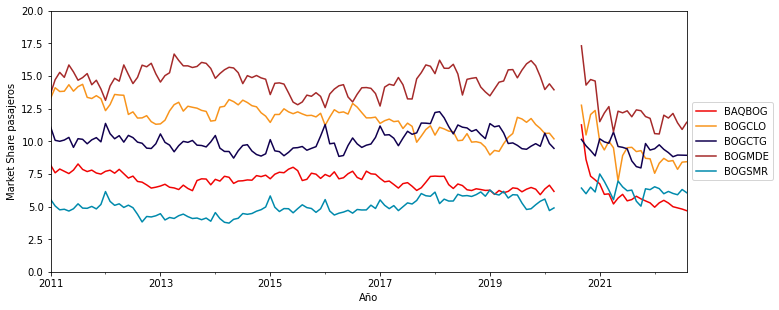

In [ ]:
# market share by MARKETleg PASAJEROS

mk_share = df_full.groupby(['Date','MarketLeg'], as_index=False)['PasajerosABordo','SillasOfrecidas'].agg('sum').sort_values(['PasajerosABordo'], ascending= False)
consol =df_full.groupby(['Date'], as_index=False)['PasajerosABordo'].agg('sum')
consol.rename(columns = {'PasajerosABordo':'PasajerosABordo_sum'}, inplace = True)



mk_share = mk_share.merge(consol, on='Date', how='left')
mk_share['m_share'] = (mk_share['PasajerosABordo']/ mk_share['PasajerosABordo_sum'])*100
mk_share['m_share'] = mk_share['m_share'].replace(0, np.nan)
#DEFINAMOS LOS MARKET LEG OBJETIVO SUJETO AL TOP 10 DE LOS SHARES POR RUTA CALCULADOS ANTERIORMENTE
mk_share = mk_share[mk_share['MarketLeg'].isin(['BOGMDE',
 'BOGCTG',
 'BOGCLO',
 'BOGSMR',
 'BAQBOG'])]

mk_share.m_share = np.where((mk_share.m_share > 90) & (mk_share.m_share < 100), np.NaN, mk_share.m_share)
pivot_mk_share =mk_share.pivot( index = 'Date', columns="MarketLeg", values="m_share")

fig = plt.figure()
w = pivot_mk_share.plot(color= ['#f00404','#f8941c','#10004f','Brown','#008AAC'])
plt.xlabel("Año")
plt.ylabel("Market Share pasajeros")
box = w.get_position()
w.set_position([box.x0, box.y0, box.width * 1.9, box.height*1.2])
w.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,20)
fig.savefig('Market_share.png')
plt.show()

In [ ]:
# HHI INDEX BY MARKETLEG AND LEG


In [ ]:
# HHI INDEX ANALYSIS  SCATTER PLOT

# Precios

## PROCESAMIENTO TABLA DE PRECIOS

In [ ]:
# PROCESAMIENTO TABLA AEROCIVIL
p_f_p =  path + file_price
data_p = pd.read_csv(p_f_p, sep="\t")
df_p =data_p


In [ ]:
# Procesemos algunos datos
df_p[['fullprice',	'Netprice', 'tax']]=df_p[['fullprice',	'Netprice', 'tax']].astype('string')

for x in ['fullprice',	'Netprice', 'tax']: 
  df_p[x]=df_p[x].apply(lambda x: x.replace(',', '.'))

df_p[['fullprice',	'Netprice', 'tax']]=round(df_p[['fullprice',	'Netprice', 'tax']].astype('float'),2)

df_p['ObservationDate'] = pd.to_datetime(df_p['ObservationDate'], format='%Y-%m-%d')
df_p['Depdate'] = pd.to_datetime(df_p['Depdate'], format='%Y-%m-%d')
df_p['Año'], df_p['Mes'], df_p['Dia'] = pd.to_datetime(df_p['Depdate']).dt.year, pd.to_datetime(df_p['Depdate']).dt.month,  pd.to_datetime(df_p['Depdate']).dt.day
df_p['Month-Year'] =  pd.to_datetime(df_p['Depdate']).dt.to_period('M')

df_p['Leg'] = df_p['Leg'].str.replace('EOH', 'MDE')

df_p =df_p.sort_values(['Año','Mes','Leg']).reset_index()




#  LIMITAMOS LAS FECHA DE PARTIDA SOLO PARA 2022
df_p = df_p[(df_p['Month-Year']<='2022-08')]


df_p_week =  df_p

#DIAS PARA LA PARTIDA
df_p['Days for depature'] = ( df_p['ObservationDate']-df_p['Depdate'] )
df_p =df_p.sort_values(['Depdate','Days for depature'])
df_p['Days for depature']= df_p['Days for depature'].dt.days



#DEFINIENDO DIFERENCIA DE SEMANAS  [ESTA APPROACH GENERA MAS NAN QUE EL DE DIAS]

# df_p_week['Weeks for depature'] = ((df_p_week['Depdate'] - df_p_week['ObservationDate']) / np.timedelta64(1, 'W')).astype(int)
  
# df_p_week =df_p_week.sort_values(['Depdate','Weeks for depature'])

# #AGRUPANDO POR SEMANAS
# df_p_week = df_p_week.groupby(['Año','Mes','Month-Year','Depdate','Carrier','Leg','Weeks for depature'], as_index=False)['fullprice','Netprice','tax'].agg('mean')
# df_p_week =df_p_week.sort_values(['Depdate','Weeks for depature'])

In [ ]:
df_p.groupby('Days for depature').count()

,index,Depdate,Carrier,Leg,ObservationDate,Netprice,fullprice,tax,Año,Mes,Dia,Month-Year
Days for depature,,,,,,,,,,,,
-329,6136,6136,6136,6136,6136,6136,6136,6136,6136,6136,6136,6136
-319,7571,7571,7571,7571,7571,7571,7571,7571,7571,7571,7571,7571
-309,8928,8928,8928,8928,8928,8928,8928,8928,8928,8928,8928,8928
-299,10387,10387,10387,10387,10387,10387,10387,10387,10387,10387,10387,10387
-289,11746,11746,11746,11746,11746,11746,11746,11746,11746,11746,11746,11746
...,...,...,...,...,...,...,...,...,...,...,...,...
-4,72971,72971,72971,72971,72971,72971,72971,72971,72971,72971,72971,72971
-3,72990,72990,72990,72990,72990,72990,72990,72990,72990,72990,72990,72990
-2,73008,73008,73008,73008,73008,73008,73008,73008,73008,73008,73008,73008


#### DAY APPROACH PIVOT PROCESS


In [ ]:
df_p_pivot = df_p.pivot( index =[ 'Año','Mes','Depdate','Carrier',"Leg"], columns=['Days for depature'], values=['fullprice'])
df_p_pivot.columns = df_p_pivot.columns.droplevel(0) 
df_p_pivot.columns.name = None
df_p_pivot = df_p_pivot.reset_index()

In [ ]:
def describe_nan(df):
    return pd.DataFrame([(i, df[df[i].isna()].shape[0],df[df[i].isna()].shape[0]/df.shape[0]) for i in df.columns], columns=['column', 'nan_counts', 'nan_rate'])

NAN_describe_for_day = describe_nan(df_p_pivot)


In [ ]:
NAN_describe_for_day

In [ ]:
#ANALISIS DE NULOS
number_null =df_p_pivot.iloc[: , 5:].isnull().groupby([df_p_pivot['Depdate'],df_p_pivot['Leg'], df_p_pivot['Carrier']]).sum().astype(int)
number_null = number_null.reset_index()

#number_null.to_excel("null_review_day_approach.xlsx")

## ANALISIS DE PRECIOS

### Curva de precios de Avianca (ruta BOGMDE, con fecha de salida en agosto de 2022)

In [ ]:
#df_p.groupby(['Date'], as_index=False)['fullprice','netprice'].agg('mean')

df_p_av = df_p[(df_p['Carrier']=='AV')& (df_p['Leg']=='BOGMDE') & (df_p['Depdate']=='2022-08-31') ]
df_p_av['SMA90'] = df_p_av['fullprice'].rolling(31).mean()
df_p_av =df_p_av.pivot( index = 'ObservationDate', columns="Depdate", values=['fullprice','SMA90'])
df_p_av = df_p_av.iloc[31-1:,]

# REMOVE THE LEVEL 


df_p_av.columns = df_p_av.columns.droplevel(1) 
df_p_av.columns.name = None
df_p_av = df_p_av.reset_index()



fig = plt.figure()
ax = plt.subplot(111)
plt.plot(df_p_av.ObservationDate, df_p_av.fullprice, label= 'Precios', color = '#008AAC')
plt.plot(df_p_av.ObservationDate,  df_p_av.SMA90, label = 'Media móvil de 90 días', color = '#002857')
plt.xlabel("Año")
plt.ylabel("Precio (COP)")
plt.title('Curva de precios de Avianca (ruta BOGMDE, con fecha de salida en agosto de 2022)')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.9, box.height*1.2])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

KeyError: ignored

### Curva de precios de Mercado (con fecha de salida en agosto de 2022

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Text(0, 0.5, 'Precio (COP)')

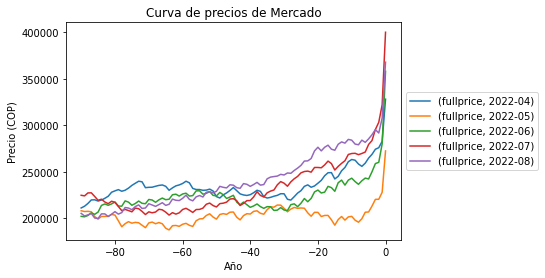

In [ ]:
mean_avg = 3
title = 'Media móvil de ' + str(int(mean_avg)) +' días' 



df_p_mk = df_p.groupby(['Month-Year', 'Days for depature'], as_index=False)['fullprice','Netprice'].agg('mean')
df_p_mk = df_p_mk[((df_p_mk['Month-Year']<= '2022-08')&(df_p_mk['Month-Year']>= '2022-04'))  & (df_p_mk['Days for depature']>=-90) ]
df_p_mk[title] = df_p_mk['fullprice'].rolling(int(mean_avg)).mean()
df_p_mk =df_p_mk.pivot( index = 'Days for depature', columns="Month-Year", values=['fullprice',title])
#df_p_mk = df_p_mk.iloc[mean_avg-1:,]



# # REMOVE THE LEVEL 
# df_p_mk.columns = df_p_mk.columns.droplevel(0) 
# df_p_mk.columns.name = None
df_p_mk = df_p_mk.reset_index()



df_p_mk



# & (df_p_mk['Days for depature']>=-90)

ax =df_p_mk.plot(x="Days for depature", y=['fullprice'], kind="line")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Curva de precios de Mercado')
plt.xlabel("Año")
plt.ylabel("Precio (COP)")

# fig = plt.figure()
# ax = plt.subplot(111)
#plt.plot(df_p_mk["Days for depature"], df_p_mk.fullprice,label =)


# plt.plot(df_p_mk["Days for depature"],  df_p_mk[title], label = title, )

#
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 1.9, box.height*1.2])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()





In [ ]:
df_1=df_p
df_p =df_1

### MEDIA MOVIL 31 DIAS PRINCIPALES AEROLINEAS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

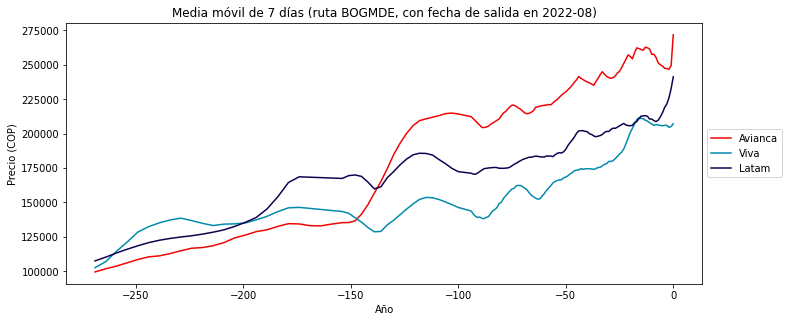

In [ ]:
from pandas.core.groupby import groupby

df_p = df_p.groupby(['Month-Year','Days for depature', 'Leg','Carrier'], as_index=False)['fullprice'].agg('mean')
mean_avg = 7
dep = '2022-08'
title = 'Media móvil de ' + str(int(mean_avg)) +' días'


df_p_av = df_p[(df_p['Carrier']=='AV')& (df_p['Leg']=='BOGMDE') & (df_p['Month-Year']==dep) ]
df_p_av[title] = df_p_av['fullprice'].rolling(mean_avg).mean()
df_p_av =df_p_av.pivot( index = 'Days for depature', columns="Month-Year", values=['fullprice',title])
df_p_av = df_p_av.iloc[mean_avg-1:,]

df_p_la = df_p[(df_p['Carrier']=='LA')& (df_p['Leg']=='BOGMDE') & (df_p['Month-Year']==dep) ]
df_p_la[title] = df_p_la['fullprice'].rolling(mean_avg).mean()
df_p_la =df_p_la.pivot( index = 'Days for depature', columns="Month-Year", values=['fullprice',title])
df_p_la = df_p_la.iloc[mean_avg-1:,]

df_p_vh = df_p[(df_p['Carrier']=='VH')& (df_p['Leg']=='BOGMDE') & (df_p['Month-Year']==dep) ]
df_p_vh[title] = df_p_vh['fullprice'].rolling(mean_avg).mean()
df_p_vh =df_p_vh.pivot( index = 'Days for depature', columns="Month-Year", values=['fullprice',title])
df_p_vh = df_p_vh.iloc[mean_avg-1:,]

# REMOVE THE LEVEL 
df_p_av.columns = df_p_av.columns.droplevel(1) 
df_p_av.columns.name = None
df_p_av = df_p_av.reset_index()


df_p_vh.columns = df_p_vh.columns.droplevel(1) 
df_p_vh.columns.name = None
df_p_vh = df_p_vh.reset_index()

df_p_la.columns = df_p_la.columns.droplevel(1) 
df_p_la.columns.name = None
df_p_la = df_p_la.reset_index()

fig = plt.figure()
ax = plt.subplot(111)
plt.plot(df_p_av['Days for depature'],  df_p_av[title], label = 'Avianca', color = '#f00404')
plt.plot(df_p_vh['Days for depature'],  df_p_vh[title], label = 'Viva', color = '#008AAC')
plt.plot(df_p_la['Days for depature'],  df_p_la[title], label = 'Latam', color = '#10004f')
plt.xlabel("Año")
plt.ylabel("Precio (COP)")
plt.title(title +' (ruta BOGMDE, con fecha de salida en '+ dep+ ')')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.9, box.height*1.2])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [ ]:
df_p_av

,Days for depature,fullprice,Media móvil de 7 días
0,-269,105578.696333,99529.041366
1,-264,105263.226667,101808.071627
2,-259,107770.363333,103778.230352
3,-254,115589.546000,106212.780057
4,-249,116720.985000,108579.969343
...,...,...,...
132,-4,247837.911935,247498.592579
133,-3,241816.655000,247184.419100
134,-2,252825.647000,246693.919528
135,-1,261653.755484,249513.734551


# Union de bases de datos

## ORGANICEMOS NUESTROS DATOS

In [ ]:
# DEFINAMOS df como dos Approach que vamos a usar
df_APP1 = df
df_APP2 = df

In [ ]:
#AGRUPEMOS POR MES EL DIA DE PARTIDA
df_p_month_day = df_p.groupby(['Año','Mes','Month-Year','Carrier','Leg','Days for depature'], as_index=False)['Netprice','fullprice','tax'].agg('mean')

df_p_month_day_APP1 = df_p_month_day
df_p_month_day_APP2 = df_p_month_day


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


## APPROACH 1

In [ ]:
# PIVOTEAMOS LA DATA
df_p_month_day_pivot_APP1 = df_p_month_day_APP1.pivot( index =[ 'Año','Mes','Month-Year','Carrier',"Leg"], columns=['Days for depature'], values=['fullprice'])
df_p_month_day_pivot_APP1.columns = df_p_month_day_pivot_APP1.columns.droplevel(0) 
df_p_month_day_pivot_APP1.columns.name = None
df_p_month_day_pivot_APP1 = df_p_month_day_pivot_APP1.reset_index()

#CREEMOS UN ID 
df_p_month_day_pivot_APP1['id'] = df_p_month_day_pivot_APP1['Año'].astype(str) + df_p_month_day_pivot_APP1['Mes'].astype(str) + df_p_month_day_pivot_APP1['Carrier'] +df_p_month_day_pivot_APP1['Leg']
df_APP1['id'] = df_APP1['Año'].astype(str) + df_APP1['Mes'].astype(str) + df_APP1['Airline_Cod'] +df_APP1['Leg']

#CONDICIONEMOS LA PRESENCIA DE DATOS EN NUESTRAS MUESTRAS PARA PODER DESARROLLAR EL EJERCICIO DE MERGE MAS ADELANTE
df_APP1 = df_APP1[df_APP1['Leg'].isin(list(df_p.groupby('Leg', as_index = False).count()['Leg']))]
df_p_month_day_pivot_APP1 = df_p_month_day_pivot_APP1[df_p_month_day_pivot_APP1['id'].isin(list(df_APP1.groupby('id', as_index = False).count()['id']))]
df_APP1 = df_APP1[df_APP1['id'].isin(list(df_p_month_day_pivot_APP1.groupby('id', as_index = False).count()['id']))]

# BORREMOS ALGUNAS COLUMNAS QUE NO USAMOS
df_p_month_day_pivot_APP1 = df_p_month_day_pivot_APP1.drop(columns=['Año','Mes','Month-Year','Carrier','Leg'])


# UNAMOS NUESTROS DATOS
full_data_APP1 = pd.merge(df_APP1,df_p_month_day_pivot_APP1, on=["id","id"])

full_data_APP1= full_data_APP1.sort_values(['Date','Leg'])

full_data_APP1.to_excel('Data_for_regresions_APP_1.xlsx')

# VOLVEMOS DATE UNA STRING PARA PODER VOLVERL DTA

full_data_APP1_to_stata = full_data_APP1

full_data_APP1_to_stata['Date'] = full_data_APP1_to_stata['Año'].astype(str)+'-' +full_data_APP1_to_stata['Mes'].astype(str)

full_data_APP1_to_stata.to_stata('Data_for_regresions_APP_1.dta')


In [ ]:

full_data_APP1[full_data_APP1['id'] == '202189RBOGMDE']


,Año,Mes,Date,CiudadDestino,Destino,Destino_MC,CiudadOrigen,Origen,Origen_MC,Leg,MarketLeg,Airline_Cod,Company,Trafico,TipoVuelo,Ruta_Viva,NumerodeVuelos,PasajerosABordo,PasajerosTransito,SillasOfrecidas,KM,LF,PDEWS,Weekly_Frequencies,id_m_share,m_share,id_HHI_treatment,HHI,HHI_O,OL_Presence,OL_entrance,AV_VH_Presence,Merge_Effect,id,-329,-319,-309,-299,-289,-280,-279,-269,-264,-259,-254,-249,-244,-239,-234,-229,-224,-220,-219,-214,-209,-204,-199,-194,-189,-184,-180,-179,-174,-169,-164,-159,-154,-151,-150,-148,-145,-142,-139,-136,-133,-130,-127,-124,-121,-120,-118,-115,-112,-110,-109,-106,-103,-100,-94,-93,-92,-91,-90,-89,-88,-87,-86,-85,-84,-83,-82,-81,-80,-79,-78,-77,-76,-75,-74,-73,-72,-71,-70,-69,-68,-67,-66,-65,-64,-63,-62,-61,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,-50,-49,-48,-47,-46,-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
108,2021,8,2021-8,MEDELLIN,MDE,MDE,BOGOTA,BOG,BOG,BOGMDE,BOGMDE,9R,Other,N,R,1.0,66.0,2929.0,0.0,3183.0,249.123333,0.906799,31.494624,2.483871,2021-08BOGMDE9R,0.021174,2021-08BOGMDE,0.353215,0.337751,1,0,1,0,202189RBOGMDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,169160.0,152780.0,189670.556667,176966.6675,182985.334,205876.111667,254325.0,250948.75,226853.125,228558.888889,239272.0


In [ ]:
full_data_APP1['id'].nunique()/ len(full_data_APP1)


1.0

In [ ]:
df_APP1.groupby(['Date'])['Leg'].count()

Date
2021-08    177
2021-09    178
2021-10    182
2021-11    184
2021-12    190
2022-01    192
2022-02    190
2022-03    243
2022-04    240
2022-05    239
2022-06    240
2022-07    233
2022-08    237
Freq: M, Name: Leg, dtype: int64

## HAGAMOS LO ANTERIOR PERO A NIVEL MES RUTA

In [ ]:
# CREEMOS EL PONDERADOR
w = df_APP1.groupby(['Airline_Cod'], as_index =  False)['SillasOfrecidas'].sum()
w['Ponderador'] =df_APP1.groupby(['Airline_Cod'], as_index =  False)['SillasOfrecidas'].sum()['SillasOfrecidas']/sum(df_APP1.groupby(['Airline_Cod'], as_index =  False)['SillasOfrecidas'].sum()['SillasOfrecidas'])

w = w[['Airline_Cod', 'Ponderador']]
w['Carrier'] =w['Airline_Cod'] 
w = w[['Carrier', 'Ponderador']]


# UNEMOS EL PONDERADOR A PRECIOS

df_p_month_day_APP1_MONTH_LEG = pd.merge(df_p_month_day_APP1,w, on=["Carrier","Carrier"])

#CREEMOS LOS PRECIOS PERO PONDERADOS

cols = ['Netprice',	'fullprice',	'tax'	]
for i in cols:
  df_p_month_day_APP1_MONTH_LEG[i] = df_p_month_day_APP1_MONTH_LEG[i]*df_p_month_day_APP1_MONTH_LEG['Ponderador']

# DEFINAMOS PRECIOS DE LA FORMA MES RUTA
df_p_month_day_APP1_MONTH_LEG = df_p_month_day_APP1_MONTH_LEG.groupby(['Año','Mes','Month-Year','Leg','Days for depature'], as_index=False)['Netprice','fullprice','tax'].agg('sum')

# DEFINAMOS CANTIDADES DE LA FORMA MES RUTA
df_APP1_MONTH_LEG =  df_APP1.groupby(['Año',	'Mes',	'Date', 'CiudadDestino','Destino','Destino_MC','CiudadOrigen','Origen','Origen_MC',
                                     'Leg', 'MarketLeg'], as_index =  False).agg({'Ruta_Viva':'sum','NumerodeVuelos':'sum', 'NumerodeVuelos':'sum','PasajerosABordo':'sum',
                                                                                                                        'PasajerosTransito':'sum','SillasOfrecidas':'sum','KM':'mean','LF':'mean',
                                                                                                                        'PDEWS':'mean','Weekly_Frequencies':'mean',
                                                                                                                        'OL_Presence': 'mean', 'OL_entrance': 'mean', 
                                                                                                                        'AV_VH_Presence':'mean','Merge_Effect':'mean', "HHI":'mean', 'HHI_O': 'mean' })
df_APP1_MONTH_LEG['Ruta_Viva'] = np.where(df_APP1_MONTH_LEG['Ruta_Viva']>=1,1,0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [ ]:
# PIVOTEAMOS LA DATA
df_p_month_day_pivot_APP1_MONTH_LEG = df_p_month_day_APP1_MONTH_LEG.pivot( index =[ 'Año','Mes','Month-Year',"Leg"], columns=['Days for depature'], values=['fullprice'])
df_p_month_day_pivot_APP1_MONTH_LEG.columns = df_p_month_day_pivot_APP1_MONTH_LEG.columns.droplevel(0) 
df_p_month_day_pivot_APP1_MONTH_LEG.columns.name = None
df_p_month_day_pivot_APP1_MONTH_LEG = df_p_month_day_pivot_APP1_MONTH_LEG.reset_index()

#CREEMOS UN ID 
df_p_month_day_pivot_APP1_MONTH_LEG['id'] = df_p_month_day_pivot_APP1_MONTH_LEG['Año'].astype(str) + df_p_month_day_pivot_APP1_MONTH_LEG['Mes'].astype(str)  +df_p_month_day_pivot_APP1_MONTH_LEG['Leg']
df_APP1_MONTH_LEG['id'] = df_APP1_MONTH_LEG['Año'].astype(str) + df_APP1_MONTH_LEG['Mes'].astype(str) +df_APP1_MONTH_LEG['Leg']

#CONDICIONEMOS LA PRESENCIA DE DATOS EN NUESTRAS MUESTRAS PARA PODER DESARROLLAR EL EJERCICIO DE MERGE MAS ADELANTE
df_APP1_MONTH_LEG = df_APP1_MONTH_LEG[df_APP1_MONTH_LEG['Leg'].isin(list(df_p.groupby('Leg', as_index = False).count()['Leg']))]
df_p_month_day_pivot_APP1_MONTH_LEG = df_p_month_day_pivot_APP1_MONTH_LEG[df_p_month_day_pivot_APP1_MONTH_LEG['id'].isin(list(df_APP1_MONTH_LEG.groupby('id', as_index = False).count()['id']))]
df_APP1_MONTH_LEG = df_APP1_MONTH_LEG[df_APP1_MONTH_LEG['id'].isin(list(df_p_month_day_pivot_APP1_MONTH_LEG.groupby('id', as_index = False).count()['id']))]

# BORREMOS ALGUNAS COLUMNAS QUE NO USAMOS
df_p_month_day_pivot_APP1_MONTH_LEG = df_p_month_day_pivot_APP1_MONTH_LEG.drop(columns=['Año','Mes','Month-Year','Leg'])


# UNAMOS NUESTROS DATOS
full_data_APP1_MONTH_LEG = pd.merge(df_APP1_MONTH_LEG,df_p_month_day_pivot_APP1_MONTH_LEG, on=["id","id"])

full_data_APP1_MONTH_LEG= full_data_APP1_MONTH_LEG.sort_values(['Date','Leg'])

full_data_APP1_MONTH_LEG.to_excel('Data_for_regresions_APP_1_MONTH_LEG.xlsx')

# VOLVEMOS DATE UNA STRING PARA PODER VOLVERL DTA

full_data_APP1_to_stata_MONTH_LEG = full_data_APP1_MONTH_LEG

full_data_APP1_to_stata_MONTH_LEG['Date'] = full_data_APP1_to_stata_MONTH_LEG['Año'].astype(str)+'-' +full_data_APP1_to_stata_MONTH_LEG['Mes'].astype(str)

full_data_APP1_to_stata_MONTH_LEG.to_stata('Data_for_regresions_APP_1_MONTH_LEG.dta')


In [ ]:
full_data_APP1_to_stata_MONTH_LEG['id'].nunique()/len(full_data_APP1_to_stata_MONTH_LEG)

1.0

## APPROACH 2

La motivacion de este segundo Approach esta motivada porque algunos datos no coinciden en AEROCIVIL y PRECIOS, porque algunas aerolineas no tienen suficiente presencia, por eso, se agruparan los Leg de P5, 9R, 9A en un Leg llamado OTH (Others)

In [ ]:
# CREEMOS EL LEG DE OTH 
#AEROCIVIL
df_APP2['Airline_Cod'] = df_APP2['Airline_Cod'].apply(lambda x: 'OTH' if x != 'AV'and
                                         x != 'LA' and
                                         x != 'VH' and
                                         x != 'VE'
                                        else ('AV' if x == 'AV' 
                                              else ('LA' if x == 'LA' 
                                                    else ('VH' if x == 'VH' 
                                                          else('VE' if x=='VE' 
                                                               else 'no match')))))
# PRECIOS
df_p_month_day_APP2['Carrier'] = df_p_month_day_APP2['Carrier'].apply(lambda x: 'OTH' if x != 'AV'and
                                         x != 'LA' and
                                         x != 'VH' and
                                         x != 'VE'
                                        else ('AV' if x == 'AV' 
                                              else ('LA' if x == 'LA' 
                                                    else ('VH' if x == 'VH' 
                                                          else('VE' if x=='VE' 
                                                               else 'no match')))))
# AGRUPEMOS PARA OBTENER EL OTH
df_APP2=df_APP2.groupby(['Año','Mes','Date', 'CiudadDestino','Destino','Destino_MC','NombreAeropuertoDestino','CiudadOrigen','Origen','Origen_MC', 'NombreAeropuertoOrigen','Leg'
      , 'MarketLeg','Airline_Cod','Company'
      ,'Trafico','TipoVuelo'] ,as_index=False).agg({'Ruta_Viva':'sum','NumerodeVuelos':'sum', 'NumerodeVuelos':'sum','PasajerosABordo':'sum','PasajerosTransito':'sum','SillasOfrecidas':'sum'
                                                      ,'KM':'mean','LF':'mean','PDEWS':'mean','Weekly_Frequencies':'mean' })
      
df_p_month_day_APP2 = df_p_month_day_APP2.groupby(['Año','Mes','Month-Year','Carrier','Leg','Days for depature'], as_index=False)['Netprice','fullprice','tax'].agg('mean')


# PIVOTEAMOS LA DATA
df_p_month_day_pivot_APP2 = df_p_month_day_APP2.pivot( index =[ 'Año','Mes','Month-Year','Carrier',"Leg"], columns=['Days for depature'], values=['fullprice'])
df_p_month_day_pivot_APP2.columns = df_p_month_day_pivot_APP2.columns.droplevel(0) 
df_p_month_day_pivot_APP2.columns.name = None
df_p_month_day_pivot_APP2 = df_p_month_day_pivot_APP2.reset_index()


# CREEMOS UN ID
df_p_month_day_pivot_APP2['id'] = df_p_month_day_pivot_APP2['Año'].astype(str) + df_p_month_day_pivot_APP2['Mes'].astype(str) + df_p_month_day_pivot_APP2['Carrier'] +df_p_month_day_pivot_APP2['Leg']
df_APP2['id'] = df_APP2['Año'].astype(str) + df_APP2['Mes'].astype(str) + df_APP2['Airline_Cod'] +df_APP2['Leg']


#CONDICIONEMOS LA PRESENCIA DE DATOS EN NUESTRAS MUESTRAS PARA PODER DESARROLLAR EL EJERCICIO DE MERGE MAS ADELANTE
df_APP2 = df_APP2[df_APP2['Leg'].isin(list(df_p.groupby('Leg', as_index = False).count()['Leg']))]
df_p_month_day_pivot_APP2 = df_p_month_day_pivot_APP2[df_p_month_day_pivot_APP2['id'].isin(list(df_APP2.groupby('id', as_index = False).count()['id']))]
df_APP2 = df_APP2[df_APP2['id'].isin(list(df_p_month_day_pivot_APP2.groupby('id', as_index = False).count()['id']))]

# UNAMOS NUESTROS DATOS
full_data_APP2 = pd.merge(df_APP2,df_p_month_day_pivot_APP2, on=["id","id"])

full_data_APP2= full_data_APP2.sort_values(['Date','Leg_x'])

full_data_APP2.to_excel('Data_for_regresions_APP_2.xlsx')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [ ]:
full_data_APP2 # len 2633

,Año_x,Mes_x,Date,CiudadDestino,Destino,Destino_MC,NombreAeropuertoDestino,CiudadOrigen,Origen,Origen_MC,NombreAeropuertoOrigen,Leg_x,MarketLeg,Airline_Cod,Company,Trafico,TipoVuelo,Ruta_Viva,NumerodeVuelos,PasajerosABordo,PasajerosTransito,SillasOfrecidas,KM,LF,PDEWS,Weekly_Frequencies,id,Año_y,Mes_y,Month-Year,Carrier,Leg_y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,100,103,106,109,110,112,115,118,120,121,124,127,130,133,136,139,142,145,148,150,151,154,159,164,169,174,179,180,184,189,194,199,204,209,214,219,220,224,229,234,239,244,249,254,259,264,269,279,280,289,299,309,319,329
9,2021,8,2021-08,BARRANQUILLA,BAQ,BAQ,BARRANQUILLA-E. CORTISSOZ,SAN ANDRES - ISLA,ADZ,ADZ,SAN ANDRES-GUSTAVO ROJAS PINILLA,ADZBAQ,ADZBAQ,OTH,Other,N,R,Si,14.0,2188.0,0.0,2526.0,814.88,0.866192,70.580645,1.580645,20218OTHADZBAQ,2021,8,2021-08,OTH,ADZBAQ,281450.000000,281350.000000,296500.000000,281500.000000,281350.000000,251350.000000,251350.000000,201350.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,2021,8,2021-08,BOGOTA,BOG,BOG,BOGOTA - ELDORADO,SAN ANDRES - ISLA,ADZ,ADZ,SAN ANDRES-GUSTAVO ROJAS PINILLA,ADZBOG,ADZBOG,AV,Avianca,N,R,Si,93.0,12284.0,0.0,14010.0,1276.95,0.876802,396.258064,10.500001,20218AVADZBOG,2021,8,2021-08,AV,ADZBOG,650193.940000,575733.335000,531837.036667,582550.000000,571276.190000,586800.000000,566133.332000,650633.335000,642577.776667,556466.665000,621466.670000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,2021,8,2021-08,BOGOTA,BOG,BOG,BOGOTA - ELDORADO,SAN ANDRES - ISLA,ADZ,ADZ,SAN ANDRES-GUSTAVO ROJAS PINILLA,ADZBOG,ADZBOG,LA,Latam,N,R,Si,94.0,14011.0,0.0,15812.0,1276.95,0.890144,225.983871,5.306452,20218LAADZBOG,2021,8,2021-08,LA,ADZBOG,546800.000000,326153.332000,337751.851111,342875.001250,377128.571429,419966.665000,437466.666000,437466.667500,448022.220000,383133.330000,325133.330000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,2021,8,2021-08,BOGOTA,BOG,BOG,BOGOTA - ELDORADO,SAN ANDRES - ISLA,ADZ,ADZ,SAN ANDRES-GUSTAVO ROJAS PINILLA,ADZBOG,ADZBOG,OTH,Other,N,R,Si,26.0,4277.0,0.0,4758.0,1276.95,0.898907,137.967742,2.935484,20218OTHADZBOG,2021,8,2021-08,OTH,ADZBOG,360500.000000,335450.000000,297470.000000,315425.000000,300350.000000,325350.000000,325350.000000,390350.000000,4